Daniel Khalil: 2205957

Philippe Des Boscs: 2176993

Christina Liu: 2205359

Github link: https://github.com/danielpkhalil/BEM-114

In [659]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

Part 1 - Volatility-Managed Factor Portfolios

a)

In [660]:
daily_ff5 = pd.read_csv('ff5_daily.csv')
daily_mom = pd.read_csv('mom_daily.csv')
ff5 = pd.read_csv('ff5.csv')
mom = pd.read_csv('mom.csv')
daily_ff5['date'] = pd.to_datetime(daily_ff5['date'], format='%Y%m%d')
daily_mom['date'] = pd.to_datetime(daily_mom['date'], format='%Y%m%d')
ff5['date'] = pd.to_datetime(ff5['date'], format='%Y%m')
mom['date'] = pd.to_datetime(mom['date'], format='%Y%m')

In [661]:
merged_daily = pd.merge(daily_ff5, daily_mom, on='date', how='outer')
merged = pd.merge(ff5, mom, on='date', how='outer')
merged.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF,mom
0,1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1,1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
2,1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
3,1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
4,1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74


b)

In [662]:
merged_daily.set_index('date', inplace=True)
rolling_variance = merged_daily.rolling(window=22, min_periods=22).var()
rolling_variance.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,mom
date,,,,,,,
1963-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN


c)

In [663]:
monthly_variances = rolling_variance.resample('M').last()

for column in monthly_variances.columns:
    monthly_variances[f'{column}_lag'] = monthly_variances[column].shift(1)

regression_results = {}

# Iterate over each column to perform regression, excluding lagged columns
for column in monthly_variances.columns:
    if '_lag' in column:
        continue
    
    clean_data = monthly_variances[[column, f'{column}_lag']].dropna()

    y = clean_data[column]
    X = clean_data[f'{column}_lag']
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    regression_results[column] = {
        'Intercept': model.params['const'],
        'Beta': model.params[f'{column}_lag'],
        'P-value': model.pvalues[f'{column}_lag'],
        'R-squared': model.rsquared
    }

results_df = pd.DataFrame(regression_results).T
print(results_df)
monthly_variances.head()

         Intercept   Beta     P-value    R-squared
Mkt-RF  5.6720e-01  0.4553   1.5070e-38   0.2073  
SMB     1.8566e-01  0.3684   8.2041e-25   0.1357  
HML     8.4120e-02  0.7494  3.5701e-132   0.5617  
RMW     4.3767e-02  0.7226  1.4263e-118   0.5223  
CMA     4.4065e-02  0.6876  4.9073e-103   0.4729  
RF      4.4952e-07  0.0252   4.9680e-01   0.0006  
mom     2.0987e-01  0.6359  2.4147e-133   0.4044  


,Mkt-RF,SMB,HML,RMW,CMA,RF,mom,Mkt-RF_lag,SMB_lag,HML_lag,RMW_lag,CMA_lag,RF_lag,mom_lag
date,,,,,,,,,,,,,,
1926-11-30,NaN,NaN,NaN,NaN,NaN,NaN,0.1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-12-31,NaN,NaN,NaN,NaN,NaN,NaN,0.1604,NaN,NaN,NaN,NaN,NaN,NaN,0.1969
1927-01-31,NaN,NaN,NaN,NaN,NaN,NaN,0.1539,NaN,NaN,NaN,NaN,NaN,NaN,0.1604
1927-02-28,NaN,NaN,NaN,NaN,NaN,NaN,0.1263,NaN,NaN,NaN,NaN,NaN,NaN,0.1539
1927-03-31,NaN,NaN,NaN,NaN,NaN,NaN,0.2052,NaN,NaN,NaN,NaN,NaN,NaN,0.1263


Our results suggest that for all of our factors except for RF, we can use the variance from one month to predict the variance in the subsequent month. The positive beta coefficients support this claim as our p-values for all factors, except for RF are well below 0.05. The very small p-values show that our coefficients are statistically significant at the 5% level and implies a high level of confidence in the fact that the relationships we observe are not the result of "chance".

The RF factor on the other hand has a p-value of 0.5 suggesting that its past variance does not serve as a good prediction of its future variance.

d)

In [664]:
# Ensure 'date' is a column in both dataframes
if 'date' not in merged.columns:
    merged.reset_index(inplace=True)
if 'date' not in monthly_variances.columns:
    monthly_variances.reset_index(inplace=True)

# Format the 'date' columns to year-month format
merged['date'] = pd.to_datetime(merged['date']).dt.to_period('M')
monthly_variances['date'] = pd.to_datetime(monthly_variances['date']).dt.to_period('M')

# Prepare the future returns columns (if not already done)
for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']:
    merged[factor + '_future'] = merged[factor]#.shift(-1)

# Merge the future returns with the lagged variances on 'date'
analysis_df = pd.merge(
    merged[['date'] + [f + '_future' for f in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']]],
    monthly_variances[['date'] + [f + '_lag' for f in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']]], 
    on='date', 
    how='outer'
)

# Drop rows where any of these necessary columns are NaN
analysis_df.dropna(subset=[f + '_future' for f in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']] +
                   [f + '_lag' for f in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']], inplace=True)

# Dictionary to store regression results
regression_results_d = {}

# Run regression for each factor using the lagged variances to predict future returns
for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']:
    y = analysis_df[factor + '_future']
    X = analysis_df[factor + '_lag']
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(y, X).fit()
    regression_results_d[factor] = {
        'Intercept': model.params['const'],
        'Beta': model.params[factor + '_lag'],
        'P-value': model.pvalues[factor + '_lag'],
        'R-squared': model.rsquared
    }

results_df_d = pd.DataFrame(regression_results_d).T
print(results_df_d)

        Intercept   Beta     P-value    R-squared
Mkt-RF   0.5858   -0.0066  9.3072e-01  1.0419e-05
SMB      0.1626    0.1418  5.3565e-01  5.2868e-04
HML      0.3219   -0.0957  5.6906e-01  4.4683e-04
RMW      0.1268    0.9881  3.0135e-04  1.7843e-02
CMA      0.0712    1.4231  5.4492e-05  2.2197e-02
mom      0.9555   -0.5920  8.8753e-07  3.2750e-02


Analyzing our results, we see that Mkt-RF's beta suggests that lagged variance can serve as a predictor of future returns but the eveidence is weak as the p-value is just above the 0.05 threshold. For SMB, the beta is also positive but it is not statistically significant. For HML, the beta is negative and the p-value is close to equal to 1. For RMW,beta is positive and the p-value is below the 0.05 threshold suggesting that increases in its lagged variance is a good predictor of increased future return. CMA also suggests a predictive relationship with a positive beta and a p-value below the 0.05 threshold. Finally, mom has a negative significant beta whch suggests that higher past variances predicts lower future returns.

e)

In [665]:

numeric_cols = monthly_variances.select_dtypes(include=[np.number]).columns
average_variances = monthly_variances[numeric_cols].mean()

# Initialize a dataframe for weighted returns including the date column
weighted_returns = pd.DataFrame(monthly_variances['date'])

# Iterate over each factor to calculate weights and weighted returns
for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']:
    c_i = average_variances[factor + '_lag']
    
    monthly_variances[f'{factor}_weight'] = c_i / monthly_variances[factor + '_lag']

    excess_returns = merged[['date', factor]].copy()
    excess_returns[f'{factor}_excess'] = excess_returns[factor] #- merged['RF']
    
    shifted_weights = monthly_variances[['date', f'{factor}_weight']].copy()
    shifted_weights[f'{factor}_weight'] = shifted_weights[f'{factor}_weight'].shift(1)
    
    combined = pd.merge(shifted_weights, excess_returns, on='date', how='inner')
    combined = combined[combined['date'] > '1963-06']

    weighted_returns[f'{factor}_weight'] = combined[f'{factor}_weight'].shift(1)
    weighted_returns[f'{factor}_excess'] = combined[f'{factor}_excess'].shift(2)
    weighted_returns[f'{factor}_weighted'] = weighted_returns[f'{factor}_weight'] * weighted_returns[f'{factor}_excess']


weighted_returns.head()

,date,Mkt-RF_weight,Mkt-RF_excess,Mkt-RF_weighted,SMB_weight,SMB_excess,SMB_weighted,HML_weight,HML_excess,HML_weighted,RMW_weight,RMW_excess,RMW_weighted,CMA_weight,CMA_excess,CMA_weighted,mom_weight,mom_excess,mom_weighted
0,1926-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1926-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1927-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1927-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1927-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


f)

In [666]:
import statsmodels.api as sm

# Define the factors for each model
capm_factors = ['Mkt-RF']
ff3_factors = ['Mkt-RF', 'SMB', 'HML']
ff5_mom_factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']

alpha_results = {factor: {} for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']}

# Function to calculate alpha
def calculate_alpha(returns, factors):
    X = merged[['date'] + factors].dropna()
    returns = returns.dropna()
    
    # Align X with the dates in returns
    X = X[X['date'].isin(returns['date'])]
    returns = returns[returns['date'].isin(X['date'])]
    
    # Drop the date column for regression
    X = X.drop(columns=['date'])
    
    y = returns.drop(columns=['date']).values.squeeze()
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    alpha = model.params['const']
    return {
        'Alpha': alpha,
        'P-value': model.pvalues['const'],
        'R-squared': model.rsquared
    }

# Calculate alphas for each factor's weighted return using different models
for factor in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']:
    weighted_return = weighted_returns[['date', f'{factor}_weighted']].dropna()
    alpha_results[factor]['CAPM'] = calculate_alpha(weighted_return, capm_factors)
    alpha_results[factor]['FF3'] = calculate_alpha(weighted_return, ff3_factors)
    alpha_results[factor]['FF5+Mom'] = calculate_alpha(weighted_return, ff5_mom_factors)

# Convert alpha results to a DataFrame
alpha_df = pd.DataFrame(alpha_results).T
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 4)

print("Alpha Results:\n", alpha_df.to_string())


Alpha Results:
                                                        CAPM                                                                                                 FF3                                                                                                FF5+Mom                                              
Mkt-RF      {'Alpha': 0.49504630344089556, 'P-value': 0.1106625559133866, 'R-squared': 0.44917976599997933}        {'Alpha': 0.4686324730681316, 'P-value': 0.13449681454431717, 'R-squared': 0.449550838543174}      {'Alpha': 0.0783233877978008, 'P-value': 0.8070747763656371, 'R-squared': 0.46926733592512737}
SMB         {'Alpha': 0.14031928010688655, 'P-value': 0.6192561276022424, 'R-squared': 0.04394830796595672}     {'Alpha': -0.04310426343709886, 'P-value': 0.8370305107924056, 'R-squared': 0.48326281529877746}   {'Alpha': -0.21384738455042807, 'P-value': 0.32322315352560915, 'R-squared': 0.49431980165311407}
HML      {'Alpha': 1.1293694483395083, 'P-value': 0.00148

Analyzing our results, we see that:
- Mkt-RF: The alpha is positive across all models (CAPM, FF3, FF5+Mom), but it’s not statistically significant at the 5% level (p-value > 0.05), indicating that the strategy does not consistently generate excess returns after adjusting for risk.
- SMB: The alpha is positive in the CAPM model but not significant. It turns negative and insignificant in the FF3 and FF5+Mom models, suggesting that the strategy does not provide significant excess returns.
- HML: The alpha is positive and significant in all models, indicating that this strategy consistently generates excess returns after adjusting for risk.
- RMW: The alpha is positive and highly significant across all models, suggesting a strong performance of this strategy after risk adjustment.
- CMA: The alpha is positive and significant in the CAPM and FF3 models but becomes insignificant in the FF5+Mom model.
- Momentum: The alpha is positive and highly significant across all models, indicating that the momentum strategy consistently generates significant excess returns after adjusting for risk.

There are several explanations as to why some strategies produce alpha even though their variance positively predicts future variance. First, by managing high variance, certain strategies can leverage temporary market inefficiencies or volatility and secure gains from that. Additionally, added risk also suggests higher returns; even though the risk is high, good timing in the execution of orders can generate returns from this added volatility that exceed the regular benchmarks like the market. In other words, the high alphas are compensation, or a risk premium, for additional risk that is taken on such as volatility exposure or liquitity shortage. Finally, one thing we also mentioned in lecture is that in times of higher volatility, it can be come possible to exploit market behaviors like behavioral biases and overreactions as certain assets can become over priced or under priced. Analyzing our results, the high and significant alphas suggest that momentum strategies are particularly effective at capturing trends and generating returns above what is predicted by the models. While momentum may exhibit high variance, its trend-following nature allows it to capitalize on persistent price movements, leading to high returns. On the other hand, the other factors might be more sensitive to periods of high volatility, leading to negative returns when volatility is high.

Question 2

Part a

In [667]:
# Build a monthly dataframe with three columns: date, factor name, and rolling variance
monthly_variances = rolling_variance.resample('M').last()
monthly_variances = monthly_variances.stack().reset_index()
monthly_variances.columns = ['date', 'factor', 'rolling_variance']

# Calculate the inverse of rolling variance
monthly_variances['inverse_variance'] = 1 / monthly_variances['rolling_variance']

# Reshape the monthly factor dataframe to have three columns: date, factor name, factor returns
monthly_returns = pd.merge(ff5, mom, on='date', how='inner')
monthly_returns = monthly_returns.drop('RF', axis=1)
monthly_returns.set_index('date', inplace=True)
monthly_returns = monthly_returns.stack().reset_index()
monthly_returns.columns = ['date', 'factor', 'factor returns']

monthly_variances['date'] = pd.to_datetime(monthly_variances['date']).dt.to_period('M')
monthly_returns['date'] = pd.to_datetime(monthly_returns['date']).dt.to_period('M')
monthly_returns.head()

,date,factor,factor returns
0,1963-07,Mkt-RF,-0.39
1,1963-07,SMB,-0.41
2,1963-07,HML,-0.97
3,1963-07,RMW,0.68
4,1963-07,CMA,-1.18


In [668]:
monthly_variances.head()

,date,factor,rolling_variance,inverse_variance
0,1926-11,mom,0.1969,5.0789
1,1926-12,mom,0.1604,6.2328
2,1927-01,mom,0.1539,6.4978
3,1927-02,mom,0.1263,7.9158
4,1927-03,mom,0.2052,4.8732


In [669]:
# Merge the reshaped monthly factor dataframe with the rolling variance dataframe on date and factor name
merged_df = pd.merge(monthly_returns, monthly_variances, on=['date', 'factor'])

# Calculate portfolio weights
merged_df['weight'] = merged_df['inverse_variance'] / merged_df.groupby('date')['inverse_variance'].transform('sum')

# Calculate lag weights using .shift()
merged_df['lag_weight'] = merged_df.groupby('factor')['weight'].shift()

# Calculate monthly volatility-managed portfolio excess returns
merged_df['portfolio_excess_return'] = merged_df['lag_weight'] * merged_df['factor returns']
portfolio_excess_return = merged_df.groupby('date')['portfolio_excess_return'].sum()
merged_df.head()

,date,factor,factor returns,rolling_variance,inverse_variance,weight,lag_weight,portfolio_excess_return
0,1963-07,Mkt-RF,-0.39,0.2237,4.4698,0.0266,NaN,NaN
1,1963-07,SMB,-0.41,0.0209,47.7603,0.2837,NaN,NaN
2,1963-07,HML,-0.97,0.0379,26.3970,0.1568,NaN,NaN
3,1963-07,RMW,0.68,0.0222,45.1273,0.2681,NaN,NaN
4,1963-07,CMA,-1.18,0.0317,31.5934,0.1877,NaN,NaN


In [670]:
portfolio_excess_return = portfolio_excess_return.reset_index()
portfolio_excess_return.columns = ['date', 'Volatility-Managed Factor_Portfolio_Returns']
portfolio_excess_return.head()

,date,Volatility-Managed Factor_Portfolio_Returns
0,1963-07,0.0000
1,1963-08,0.2986
2,1963-09,-0.3259
3,1963-10,0.4044
4,1963-11,0.1327


Part b

In [671]:
# Merge for regression
factors = pd.merge(ff5, mom, on='date', how='inner')
factors['date'] = pd.to_datetime(factors['date']).dt.to_period('M')
merge = pd.merge(portfolio_excess_return, factors, on=['date'])

In [672]:
# CAPM: R_p = alpha + beta*R_m + error
X_capm = sm.add_constant(merge['Mkt-RF'])  # Adds a constant term to the regression
y = merge['Volatility-Managed Factor_Portfolio_Returns']
model_capm = sm.OLS(y, X_capm).fit()
print(model_capm.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Volatility-Managed Factor_Portfolio_Returns   R-squared:                       0.005
Model:                                                     OLS   Adj. R-squared:                  0.003
Method:                                          Least Squares   F-statistic:                     3.475
Date:                                         Mon, 13 May 2024   Prob (F-statistic):             0.0627
Time:                                                 03:07:28   Log-Likelihood:                -1061.9
No. Observations:                                          729   AIC:                             2128.
Df Residuals:                                              727   BIC:                             2137.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust  

In [673]:
X_ff3 = merge[['Mkt-RF', 'SMB', 'HML']]
X_ff3 = sm.add_constant(X_ff3)
model_ff3 = sm.OLS(y, X_ff3).fit()
print(model_ff3.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Volatility-Managed Factor_Portfolio_Returns   R-squared:                       0.388
Model:                                                     OLS   Adj. R-squared:                  0.385
Method:                                          Least Squares   F-statistic:                     152.9
Date:                                         Mon, 13 May 2024   Prob (F-statistic):           8.92e-77
Time:                                                 03:07:28   Log-Likelihood:                -884.92
No. Observations:                                          729   AIC:                             1778.
Df Residuals:                                              725   BIC:                             1796.
Df Model:                                                    3                                         
Covariance Type:                                     nonrobust  

In [674]:
X_ff5_mom = merge[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']]
X_ff5_mom = sm.add_constant(X_ff5_mom)  # Adds a constant term to the regression
model_ff5_mom = sm.OLS(y, X_ff5_mom).fit()
print(model_ff5_mom.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Volatility-Managed Factor_Portfolio_Returns   R-squared:                       0.712
Model:                                                     OLS   Adj. R-squared:                  0.710
Method:                                          Least Squares   F-statistic:                     298.2
Date:                                         Mon, 13 May 2024   Prob (F-statistic):          1.24e-191
Time:                                                 03:07:28   Log-Likelihood:                -609.25
No. Observations:                                          729   AIC:                             1233.
Df Residuals:                                              722   BIC:                             1265.
Df Model:                                                    6                                         
Covariance Type:                                     nonrobust  

Based on the regression results, the aggregate portfolio seems to perform worse (as measured by alpha) than each composite volatility-managed portfolio except for the SMB factor portfolio. The alphas of the aggregate portfolio are lower than the alphas of the Mkt-Rf, HML, RMW, CMA, and MOM portfolios. This suggests that while the aggregate portfolio effectively diversifies away some risks and improves performance, it may not always outperform every individual volatility-managed portfolio. However, the P-values for each of the composite (excluding HML and CMA) are not statistically significant, suggesting that their alphas could be the result of random chance. On the other hand, the P-values of the aggregate portfolio are statistically significant, meaning that the excess returns are likely due to the effectiveness of the strategy. Overall, the alphas for the aggregate portfolio are slightly smaller but are statistically significant unlike those of each composite portfolio.

Part c

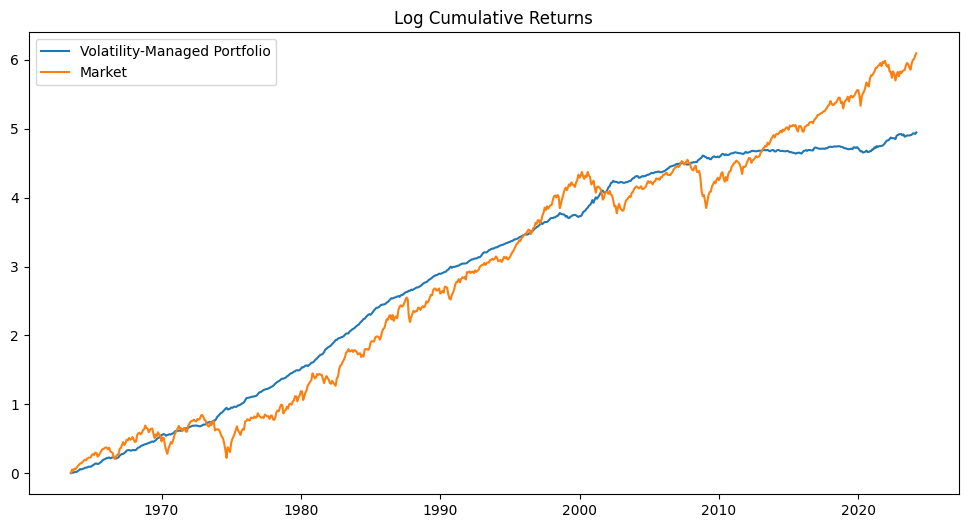

In [675]:
import numpy as np
import matplotlib.pyplot as plt

# Convert 'date' to datetime
merge['date'] = merge['date'].dt.to_timestamp()

# Calculate the log cumulative returns
merge['log_cumulative_portfolio'] = np.log(1 + (merge['Volatility-Managed Factor_Portfolio_Returns']+merge['RF'])/100).cumsum()
merge['log_cumulative_market'] = np.log(1 + (merge['Mkt-RF']+merge['RF'])/100).cumsum()

# Plot the log cumulative returns
plt.figure(figsize=(12,6))
plt.plot(merge['date'], merge['log_cumulative_portfolio'], label='Volatility-Managed Portfolio')
plt.plot(merge['date'], merge['log_cumulative_market'], label='Market')
plt.legend()
plt.title('Log Cumulative Returns')
plt.show()


C:\Users\danie\AppData\Local\Temp\ipykernel_16652\274251326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_2000_onwards['log_cumulative_portfolio'] = np.log(1 + (merge_2000_onwards['Volatility-Managed Factor_Portfolio_Returns']+merge_2000_onwards['RF'])/100).cumsum()
C:\Users\danie\AppData\Local\Temp\ipykernel_16652\274251326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_2000_onwards['log_cumulative_market'] = np.log(1 + (merge_2000_onwards['Mkt-RF']+merge_2000_onwards['RF'])/100).cum

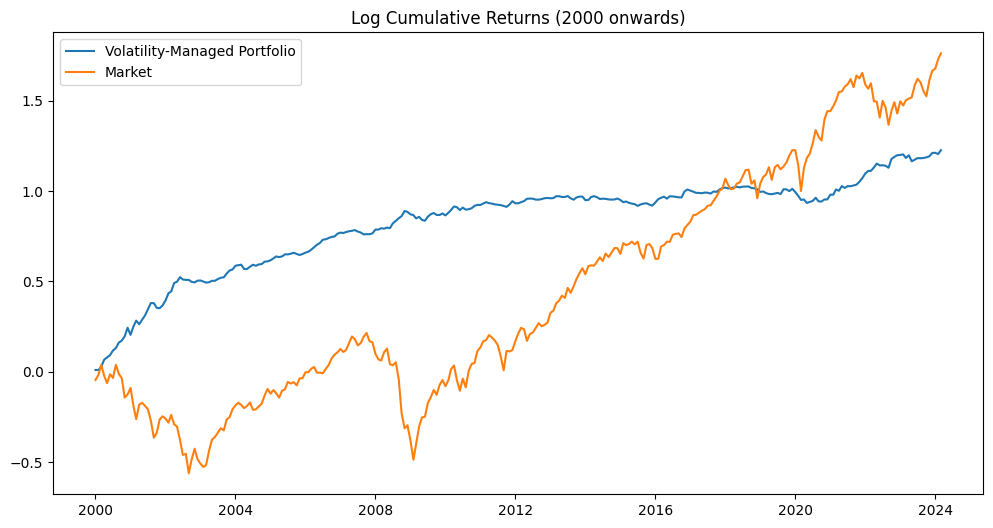

In [676]:
# Filter the dataframe for dates from the year 2000 onwards
merge_2000_onwards = merge[merge['date'].dt.year >= 2000]

# Calculate the log cumulative returns
merge_2000_onwards['log_cumulative_portfolio'] = np.log(1 + (merge_2000_onwards['Volatility-Managed Factor_Portfolio_Returns']+merge_2000_onwards['RF'])/100).cumsum()
merge_2000_onwards['log_cumulative_market'] = np.log(1 + (merge_2000_onwards['Mkt-RF']+merge_2000_onwards['RF'])/100).cumsum()

# Plot the log cumulative returns
plt.figure(figsize=(12,6))
plt.plot(merge_2000_onwards['date'], merge_2000_onwards['log_cumulative_portfolio'], label='Volatility-Managed Portfolio')
plt.plot(merge_2000_onwards['date'], merge_2000_onwards['log_cumulative_market'], label='Market')
plt.legend()
plt.title('Log Cumulative Returns (2000 onwards)')
plt.show()


In the first plot, we can see that the volatility-managed portfolio does not beat the market, despite having a positive alpha. One possible explanation for this is that the volatilty-managed portfolio's low beta, which is close to 0. Since the portolfio has a low beta (meaning its returns are not explained by the market), its returns are mostly explained by its alpha, so eventhough the strategy produces positive alpha, it is uncorrelated with the market so it does not necessarily have to beat the market in cumulative returns. It is also important to  note that the low beta of the portfolio indicates that its returns are less sensitive to market movements, which is consistent with the goal of volatility management. When compared to the market, the returns of the startegy seem to be almost always increasing, even if it is at a slower rate. A low beta could contribute to the portfolio’s ability to generate alpha by reducing exposure to market downturns. However, it could also limit the portfolio’s upside potential during market upturns, which might explain why the portfolio does not beat the market in terms of cumulative returns. In the second plot, since the turn of the century in 2000, the volatility-managed portfolio has generally kept up with or outperformed the market up until around 2020. Additionally, the volatility-managed approach seems to have provided protection during market downturns. This plateau in performance may be due to the over-saturation of the volatility strategy as it became more well-known, resulting in the strategy being priced in, making it harder to profit with the strategy. 
